In [1]:
import os

import pandas as pd
import numpy as np
from itertools import combinations      
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from tqdm import tqdm
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

from ete3 import Tree

In [2]:
sns.set_style("whitegrid")
sns.set_context("paper")

In [3]:
div_time = {'mr': 13.10, 'cs': 24.60,'hr': 28.82, 'cd': 55.4, 'csp': 61.8,'cspcd': 76.0,'mrr': 79.0,  'hrmrr': 87.2, 'hrmrrcspcd': 94.0, 'hrmrrcspcdc': 318.9, 'hrmrrcspcdcz': 429.0}
alignment_code_to_species_legend = {
    'mr': 'Mouse/Rat',
    'cs': 'Cow/Sheep',
    'hr': 'Human/Rhesus',
    'cd': 'Cat/Dog',
    'csp': 'Pig/Cow/Sheep',
    'cspcd': 'Pig/Cow/Sheep/Dog/Cat',
    'mrr': 'Mouse/Rabbit/Rat',
    'hrmrr': 'Human/Mouse/Rhesus/Rabbit/Rat',
    'hrmrrcspcd': 'Mammals',
    'hrmrrcspcdc': 'Mammals/Chicken',
    'hrmrrcspcdcz': 'Mammals/Chicken/Zebrafish'
}

In [4]:
colors = {'mr': "#033270", 
          'cs': "#1368AA", 
          'hr': "#4091C9",
          'cd': "#4AA8CD",
          'csp': "#BA746B",
          'cspcd': "#F29479",
          'mrr': "#F26A4F",
          'hrmrr': "#EF3C2D", 
          'hrmrrcspcd': "#CB1B16", 
          'hrmrrcspcdc': "#980E11",
          'hrmrrcspcdcz': "#65010C"
          }

colors_sorted = {i:colors[i] for i in colors.keys() }

In [5]:
def get_code_conversion(code):
    alignment_code_to_species = {'hr':          'human;rhesus',
                                 'mr':          'mouse;rat',
                                 'cd':          'cat;dog',
                                 'cs':          'cow;sheep',
                                 'csp':         'pig;cow;sheep',
                                 'mrr':         'mouse;rabbit;rat',
                                 'cspcd':       'pig;cow;sheep;dog;cat',
                                 'hrmrr':       'human;mouse;rhesus;rabbit;rat',
                                 'hrmrrcspcd':  'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat',
                                 'hrmrrcspcdc': 'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat;chicken',
                                 'hrmrrcspcdcz':'human;mouse;rhesus;rabbit;rat;pig;cow;sheep;dog;cat;chicken;zfish'}
    return alignment_code_to_species.get(code)

In [6]:
def get_sb_len(species,aln,path="/Users/fabianpa/Desktop/new_sequences/synteny_3/synteny_bed"):
    sb_dfs = []
    for common_name in species:
        fname = os.path.join(path,common_name+"_"+aln+".bed")
        sb_df = pd.read_table(fname, names=("chr", "start", "stop", "aln", "strand"),header=None)
        sb_df["species"] = common_name
        sb_df["sb_length"]  = sb_df["stop"]- sb_df["start"]
        sb_dfs.append(sb_df)
    return pd.concat(sb_dfs, axis=0)

def get_tad_in_sb(species, aln,sb_coord,sb_specific_aln=None,shuffle=False,coord_path="/Users/fabianpa/Desktop/new_sequences/sb_in_tad_3/"):
    count_df = []
    coord_df = []
    for common_name in species:
        coord_fname = os.path.join(coord_path, f"{common_name.lower()}_{aln}.tad.sb")
        # coord_fname = os.path.join(coord_path, f"{common_name.lower()}_{aln}.tad.sb.bed")
        specie_aln_name = common_name.lower()+"_"+aln
        try:
            sb_tad_coord = pd.read_csv(coord_fname,sep="\t",usecols=[5,6,7,3,4], names=("aln", "strand", "chr", "start", "stop"),header=None)[["chr", "start", "stop", "aln", "strand"]]
            sb_tad_coord["species"] = common_name
            sb_tad_coord["tad_size"] = sb_tad_coord["stop"] - sb_tad_coord["start"]
            if sb_specific_aln :  coord_df.append(sb_tad_coord[sb_tad_coord.aln.isin(sb_specific_aln[specie_aln_name])])
            else: coord_df.append(sb_tad_coord)
            count_list = []
            for i in sb_coord.aln.unique():
                count = len(sb_tad_coord[(sb_tad_coord.aln==i)])
                count_list.append([i,count,common_name])
                
            if sb_specific_aln :
                df = pd.DataFrame(count_list, columns=['aln', 'count',"species"])
                if shuffle:df["count"] = df["count"].sample(frac=1).values
                count_df.append(df[df["aln"].isin(sb_specific_aln[specie_aln_name])])
            else: count_df.append(pd.DataFrame(count_list, columns=['aln', 'count',"species"]))

        except FileNotFoundError as e:
            raise FileNotFoundError(f"File not found: {e.filename}")
    return count_df, coord_df

In [7]:
def get_equal_tad_count_syn_blocks(tad_count, species):
    """
    Get syntenic blocks with equal TAD counts.

    This function takes a DataFrame of TAD counts and retrieves the syntenic blocks that have equal TAD counts
    between the two specified species.

    Parameters
    ----------
    tad_count : pandas.DataFrame containing TAD counts.
    species: list of species names.

    Returns
    -------
    list
        List of syntenic blocks with equal TAD counts.

    Notes
    -----
    The TAD counts DataFrame should have columns "species", "aln", and "count" containing species name, alignment
    identifier, and TAD count respectively.
    """

    s1_count = tad_count.loc[(tad_count.species == species[0])]
    s2_count = tad_count.loc[(tad_count.species == species[1])]
    count_diff = s1_count["count"] - s2_count["count"]
    count_diff_df = pd.DataFrame({"aln": s1_count.aln, "count_s1": s1_count["count"],
                                  "count_s2":s2_count["count"], "count_diff": count_diff})
    return count_diff_df.loc[(count_diff_df["count_diff"] == 0) & (count_diff_df["count_s1"] != 0), "aln"].values.tolist()

def map_tad_boundaries(comb_df, syn_block, species):
    filtered_tad_coord = comb_df[
            (comb_df["aln"].isin(syn_block)) &
            (comb_df["species"].isin(species))
        ].copy()

    chr_y = filtered_tad_coord.loc[filtered_tad_coord.chr=="chrY","aln"].unique()
    filtered_tad_coord = filtered_tad_coord[~filtered_tad_coord['aln'].isin(chr_y)]

    tad_s1 = filtered_tad_coord.loc[ (filtered_tad_coord.species == species[0]),["start", "stop","aln"]]
    tad_s2 = filtered_tad_coord.loc[ (filtered_tad_coord.species == species[1]),["start", "stop","aln"]]

    scaler = MinMaxScaler(feature_range=(0, 1))
    sb = tad_s1['aln'].unique()
    s1_map = [
        np.unique(
            scaler.fit_transform(
                tad_s1.loc[tad_s1['aln'] == block, ['start', 'stop']]
                .sort_values(by='start')
                .values.flatten().reshape(-1, 1)
            )
        )[1:-1].tolist()
        for block in sb
        if len(tad_s1.loc[tad_s1['aln'] == block, ['start', 'stop']].sort_values(by='start')) > 1
    ]
    
    s2_map = [
        np.unique(
            scaler.fit_transform(
                tad_s2.loc[tad_s2['aln'] == block, ['start', 'stop']]
                .sort_values(by='start')
                .values.flatten().reshape(-1, 1)
            )
        )[1:-1].tolist()
        for block in sb
        if len(tad_s2.loc[tad_s2['aln'] == block, ['start', 'stop']].sort_values(by='start')) > 1
    ]
    x = [item for sublist in s1_map for item in sublist]
    y = [item for sublist in s2_map for item in sublist]
    
    res = stats.linregress(x, y)
    r2 = res.rvalue**2
    p_val=res.pvalue
    return r2,p_val,x,y

In [8]:
tad_sim = []
pbar = tqdm(div_time.keys(), desc='Processing Alignment')

for aln in pbar:
    pbar.set_description(f'Processing Alignment -> {aln}')

    species = get_code_conversion(aln).split(';')

    sb_coord = get_sb_len(species,aln)
    tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)

    tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
    tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)

    comb = list(combinations(species, 2))
    size_similarity = []
    size_similarity_rdm = []
    border_similarity = []
    p_values =[]
    for i in comb:
        syn_block = get_equal_tad_count_syn_blocks(tad_sb_count_df, i)
        comb_df = (tad_sb_coord_df.loc[(tad_sb_coord_df.species == i[0]) | (tad_sb_coord_df.species == i[1])])

        r2,pval,s1_coord,s2_coord= map_tad_boundaries(comb_df, syn_block,i)
        border_similarity.append(r2)
        p_values.append(pval)

    test_statistic, combined_p_value =  stats.combine_pvalues(p_values, method='fisher')
    tad_sim.append([aln, div_time[aln],np.mean(border_similarity),combined_p_value,p_values])

df = pd.DataFrame(tad_sim, columns=['alignment', 'mya','tad_border_similarity',"pvalue","p_val_distr"])

Processing Alignment -> hrmrrcspcdcz: 100%|██████████| 11/11 [00:31<00:00,  2.82s/it]


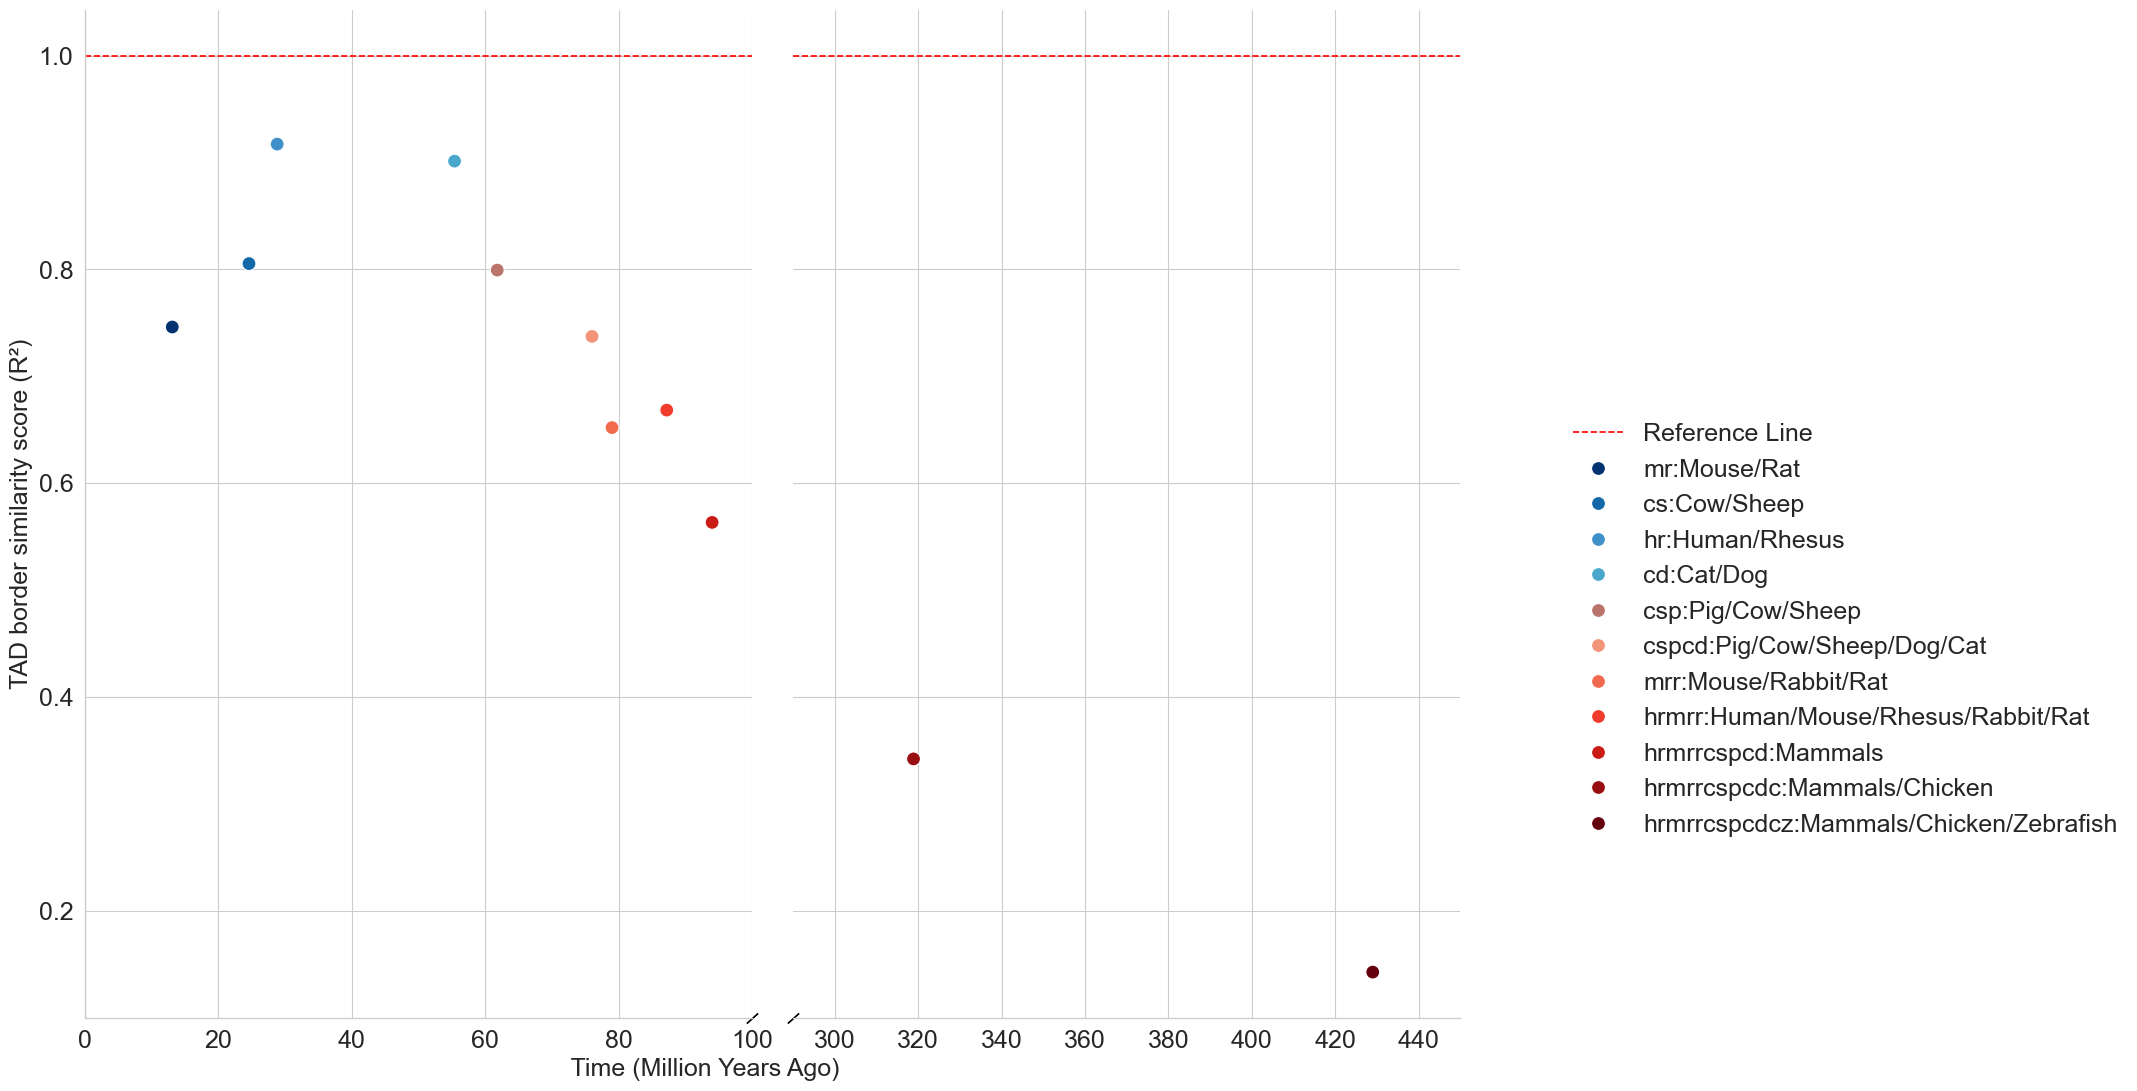

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,11))
fig.subplots_adjust(wspace=0.2)  # adjust space between axes

ax1.axhline(y=1, color='r',linestyle="--")
ax2.axhline(y=1, color='r',linestyle="--",label="Reference Line")

# plot the same data on both axes
sns.scatterplot(data=df, x="mya", y="tad_border_similarity",hue="alignment",ax=ax1,legend=False,palette=list(colors_sorted.values()),s=100)
sns.scatterplot(data=df, x="mya", y="tad_border_similarity",hue="alignment",ax=ax2,palette=list(colors_sorted.values()),legend=True,s=100)

# zoom-in / limit the view to different portions of the data
ax1.set_xlim(0, 100) # most of the data
ax2.set_xlim(290, 450)   # outliers only


# hide the spines between ax and ax2
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)
ax2.spines.left.set_visible(False)
ax2.spines.right.set_visible(False)
ax2.spines.top.set_visible(False)

# Now, let's turn towards the cut-out slanted lines.
d = .9  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 0], transform=ax2.transAxes, **kwargs)
ax1.set_xlabel("                                                                                  Time (Million Years Ago)",fontsize=18)
ax1.set_ylabel(f"TAD border similarity score (R\N{SUPERSCRIPT TWO})",fontsize=18)
ax2.set(xlabel="", ylabel="")
ax1.yaxis.set_tick_params(labelsize=18)
ax1.xaxis.set_tick_params(labelsize=18)
ax2.xaxis.set_tick_params(labelsize=18)
plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
labels = [f"{label}:{alignment_code_to_species_legend[label]}" if label in alignment_code_to_species_legend.keys() else label for label in labels]
plt.legend(handles=handles[:], labels=labels[:],bbox_to_anchor=(2, 0.6), borderaxespad=0,frameon=False,fontsize=18)
# plt.savefig("images/tad_border_r2.png", bbox_inches='tight')
plt.show()

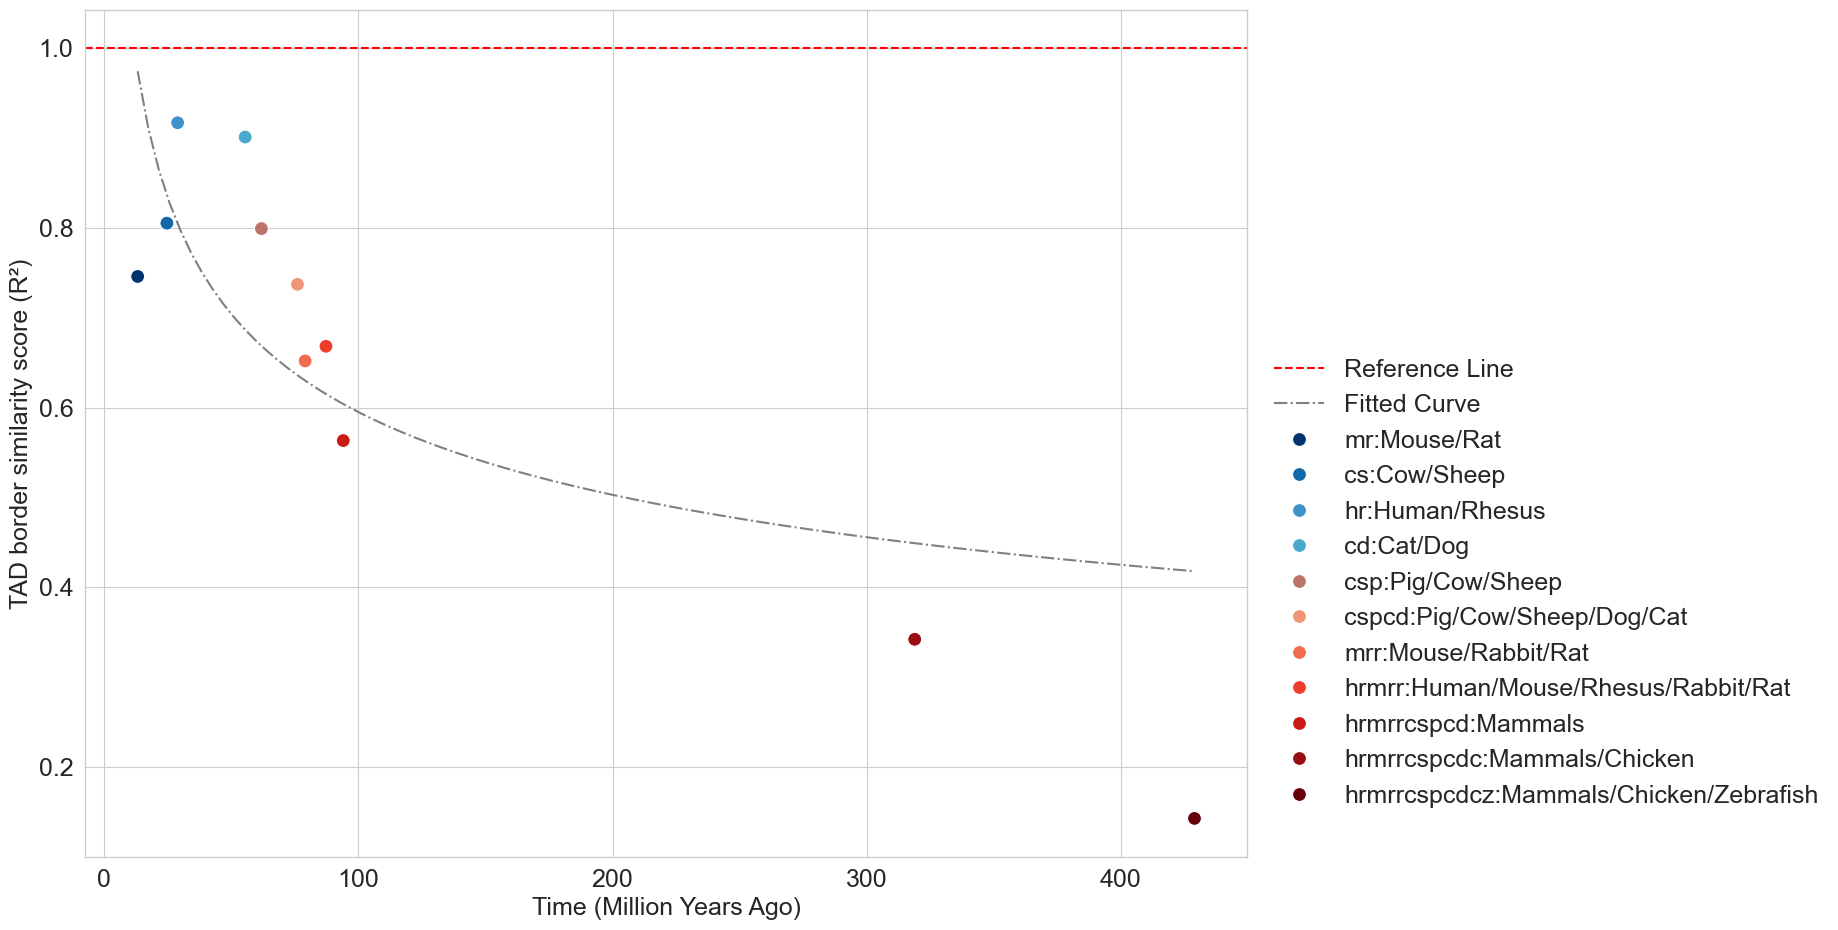

In [10]:
def power_law(x, a, b):
    return a*np.power(x, b)

x_data = df["mya"]
y_data = df["tad_border_similarity"]

plt.figure(figsize=(15, 11)) 

# Fit the data to the exponential decay function
params, covariance = curve_fit(power_law, x_data, y_data)

# Extract the parameter estimates and standard deviations
a, b = params
a_std, b_std = np.sqrt(np.diag(covariance))

# Generate the fitted curve and confidence interval curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = power_law(x_fit, a, b)


plt.axhline(y=1, color='r',linestyle="--",label='Reference Line',linewidth=1.5)
sns.lineplot(x=x_fit, y=y_fit, color='grey', linestyle="-.",label='Fitted Curve',linewidth=1.5)

# Scatter plot for data points
sns.scatterplot(data=df, x="mya", y="tad_border_similarity", hue="alignment",palette=list(colors_sorted.values()),s=100)

# Add labels and legend
plt.xlabel("Time (Million Years Ago)",fontsize=18)
plt.ylabel(f"TAD border similarity score (R\N{SUPERSCRIPT TWO})",fontsize=18)
handles, labels = plt.gca().get_legend_handles_labels()
labels = [f"{label}:{alignment_code_to_species_legend[label]}" if label in alignment_code_to_species_legend.keys() else label for label in labels]
plt.legend(handles=handles[:], labels=labels[:],bbox_to_anchor=(1.5, 0.6), borderaxespad=0,frameon=False,fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
# plt.savefig("images/tad_border_r2_fitted.png", bbox_inches='tight')
plt.show()

In [11]:
df

,alignment,mya,tad_border_similarity,pvalue,p_val_distr
0,mr,13.10,0.746111,9.910208e-33,[9.910207938199036e-33]
1,cs,24.60,0.805425,1.901925e-07,[1.9019250176144647e-07]
2,hr,28.82,0.917236,8.793254e-42,[8.79325424307569e-42]
3,cd,55.40,0.901306,3.566712e-122,[3.566712034969237e-122]
4,csp,61.80,0.799365,6.056244e-242,"[1.0797827013768068e-57, 5.963908314548524e-12..."
5,cspcd,76.00,0.737326,0.000000e+00,"[2.7616874228664323e-87, 1.623825177203499e-92..."
6,mrr,79.00,0.652018,1.484472e-146,"[5.499690900629846e-39, 1.101923755852086e-79,..."
7,hrmrr,87.20,0.668365,0.000000e+00,"[3.766869054734251e-38, 9.13086694675948e-152,..."
8,hrmrrcspcd,94.00,0.563330,0.000000e+00,"[8.794007441411307e-31, 4.439323214835477e-65,..."
9,hrmrrcspcdc,318.90,0.342046,0.000000e+00,"[2.0194185118985133e-26, 1.1261972894107022e-3..."


In [23]:
# slope, intercept, r_value, p_value, std_err = stats.linregress(df["mya"], df["tad_border_similarity"])
# slope

-0.0016657414608434364

SINGLE BLOCK PLOTS 

In [12]:
def calc_border_similarity(mapped_tads): 
    # Calculate the border similarity between species 1 and species 2
    s1,s2 = list(mapped_tads.keys())[0],list(mapped_tads.keys())[1]
    if len(mapped_tads[s1])==2: return None
    x = mapped_tads[s1]
    y = mapped_tads[s2]
    res = stats.linregress(x, y)
    r2 = res.rvalue**2
    p_val=res.pvalue
    return r2

def map_tad_boundaries_single(tad_coord, species):
    tad_coord.sort_values(by=['start'], inplace=True)
    result_similarity = []
    tad_bord = []
    for code in tad_coord.aln.unique():

        species_coord = {sp: tad_coord.loc[(tad_coord.aln == code) & (tad_coord.species == sp), ["start", "stop"]] for sp in species}

        # Map the TAD boundaries to the range [0, 1]
        scaler = MinMaxScaler(feature_range=(0, 1))
        mapped_tads = {sp: np.unique(scaler.fit_transform(coord.values.flatten().reshape(-1, 1))) for sp, coord in species_coord.items() if not coord.empty}
        tad_bord.append(mapped_tads)
        # Compute the TADs similarity
        border_similarity = calc_border_similarity(mapped_tads)
        
        if border_similarity is not None: result_similarity.append([code,border_similarity,species,len(mapped_tads[species[0]])])
        
    df_similarity = pd.DataFrame(result_similarity, columns=['Aln', 'Border Similarity','pair',"len"])
    return df_similarity,tad_bord

In [13]:
def contains_chicken(species_tuple):
    return 'chicken' in species_tuple

In [14]:
aln = "hrmrrcspcdc" 
tree = Tree("vertebrate_tree_mya.nw", format=1)
root_node = tree.get_tree_root()
species = get_code_conversion(aln).split(';')

sb_coord = get_sb_len(species,aln)
tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)

tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)

for i in tad_sb_count_df.aln.unique()[:20]:
    count = tad_sb_count_df.loc[tad_sb_count_df.aln == i]
    filtered_df = count.groupby('count').size().sort_values(ascending=False)
    if len(filtered_df)>0:
        # if len(filtered_df.index)>2: max_count = filtered_df.index[2]
        # else: continue
        max_count = filtered_df.index[0]
        count = count[count['count'] == max_count]
        comb = list(combinations(count.species, 2))
        res= []
    
    for s1,s2 in comb:
        node1 = tree.search_nodes(name=s1)[0]
        node2 = tree.search_nodes(name=s2)[0]
        parent_node = tree.get_common_ancestor(node1, node2)
        distance = round(parent_node.get_distance(node1))
        # distance = node1.get_distance(node2)
        tad_coord = tad_sb_coord_df.loc[((tad_sb_coord_df.species == s1) | (tad_sb_coord_df.species == s2))& (tad_sb_coord_df.aln==i)].copy()
        result,bound =map_tad_boundaries_single(tad_coord, (s1,s2))
        if not result.empty:
            score = result['Border Similarity'].values[0]
            res.append([(s1,s2),distance,score])
    if len(res)>1:
        r2_df = pd.DataFrame(res,columns=["species","distance","r2"])
        if r2_df['species'].apply(contains_chicken).any():  
            print(i)
            sorted_by_distance = r2_df.sort_values(by=['distance', 'r2'], ascending=[True, False]).species.values
            sorted_by_r2 = r2_df.sort_values(by='r2',ascending=False).species.values
            print(r2_df.sort_values(by=['distance', 'r2'], ascending=[True, False]))
            
        # if r2_df['species'].str.contains('human').any() : print(i)
        # if (r2_df['r2'] <= .60).any():print(i)
        # sorted_by_distance = r2_df.sort_values(by='distance',ascending=True).species.values
        # sorted_by_r2 = r2_df.sort_values(by='r2',ascending=False).species.values
        # sorted_by_distance = r2_df.sort_values(by=['distance', 'r2'], ascending=[True, False])
        # sorted_by_distance = r2_df.sort_values(by=['distance', 'r2'], ascending=[True, False]).species.values
        # same_order = (all(x == y for x, y in zip(sorted_by_r2, sorted_by_distance)))
        # if same_order: print(i,len(sorted_by_r2)) 


Alignment102
             species  distance        r2
9       (cow, sheep)        22  0.933236
6       (pig, sheep)        62  0.970277
5         (pig, cow)        62  0.822702
7         (pig, cat)        76  0.999891
12      (sheep, cat)        76  0.966623
10        (cow, cat)        76  0.814646
0       (mouse, pig)        93  0.999947
3       (mouse, cat)        93  0.999685
2     (mouse, sheep)        93  0.972709
1       (mouse, cow)        93  0.828249
4   (mouse, chicken)       318  0.983530
13  (sheep, chicken)       319  0.998611
8     (pig, chicken)       319  0.981618
14    (cat, chicken)       319  0.978704
11    (cow, chicken)       319  0.913443
Alignment108
          species  distance        r2
0      (rat, pig)        94  0.746809
2  (pig, chicken)       319  0.979957
1  (rat, chicken)       319  0.858798
Alignment109
            species  distance        r2
4      (cow, sheep)        22  0.941611
5        (cow, dog)        76  0.996526
7      (sheep, dog)        76  0.

## Illustration plot 

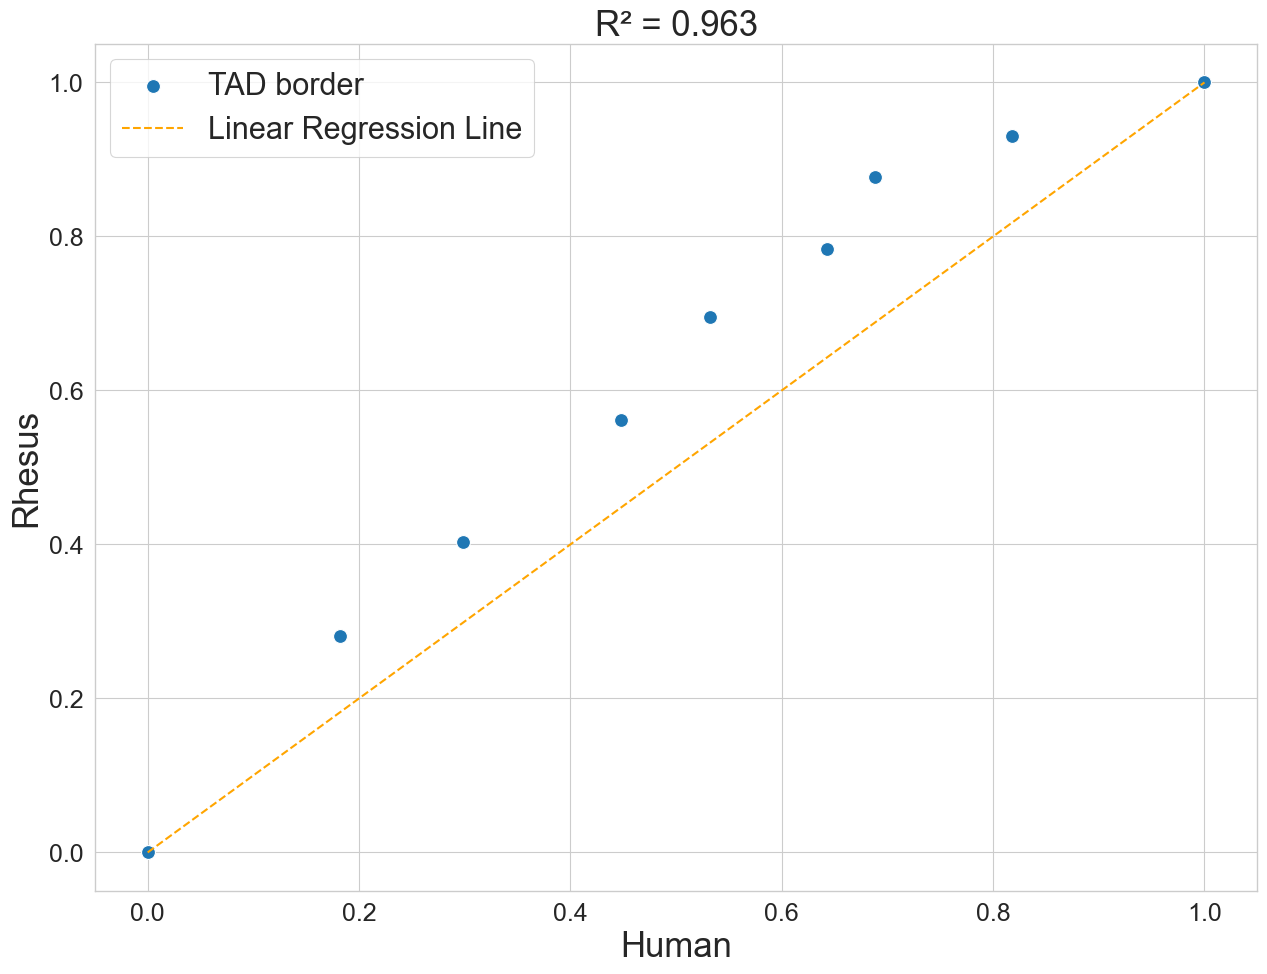

In [38]:
aln = "hr" 
species = get_code_conversion(aln).split(';')

sb_coord = get_sb_len(species,aln)
tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)

plt.figure(figsize=(15, 11)) 
tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)
i = ("human","rhesus")
syn_block = ["Alignment51"]
tad_coord = tad_sb_coord_df.loc[((tad_sb_coord_df.species == i[0]) | (tad_sb_coord_df.species == i[1]))& (tad_sb_coord_df.aln.isin(syn_block))].copy()
result,bound =map_tad_boundaries_single(tad_coord, i)
mapped_tad_boundaries = pd.DataFrame.from_dict(bound[0])
sns.scatterplot(data=mapped_tad_boundaries, x="human", y="rhesus",label="TAD border",s=100)
sns.lineplot(x=[0, 1], y=[0, 1],color='orange',linestyle='--', label="Linear Regression Line",zorder=10,linewidth=1.5)
plt.xlabel("Human",fontsize=25)
plt.ylabel("Rhesus",fontsize=25)
plt.legend(fontsize=22)
plt.title( "R\N{SUPERSCRIPT TWO} = {:.3f}".format(result['Border Similarity'].values[0]),fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.savefig("../images/tad_border_r2_line_h_rh_51.illustration.png", bbox_inches='tight')
plt.show()

28
              species  distance        r2
18       (cow, sheep)        22  0.915486
25         (dog, cat)        55  0.931414
13         (pig, cow)        62  0.913354
14       (pig, sheep)        62  0.734729
20         (cow, cat)        76  0.999985
22       (sheep, dog)        76  0.998746
19         (cow, dog)        76  0.932534
16         (pig, cat)        76  0.915537
23       (sheep, cat)        76  0.914150
15         (pig, dog)        76  0.765370
0     (human, rabbit)        86  0.770717
1        (human, pig)        93  0.923717
5        (human, cat)        93  0.709261
2        (human, cow)        93  0.705705
4        (human, dog)        93  0.544804
3      (human, sheep)        93  0.510993
11      (rabbit, cat)        94  0.987862
8       (rabbit, cow)        94  0.987225
7       (rabbit, pig)        94  0.952506
10      (rabbit, dog)        94  0.866672
9     (rabbit, sheep)        94  0.843405
6    (human, chicken)       318  0.921196
26     (dog, chicken)       318

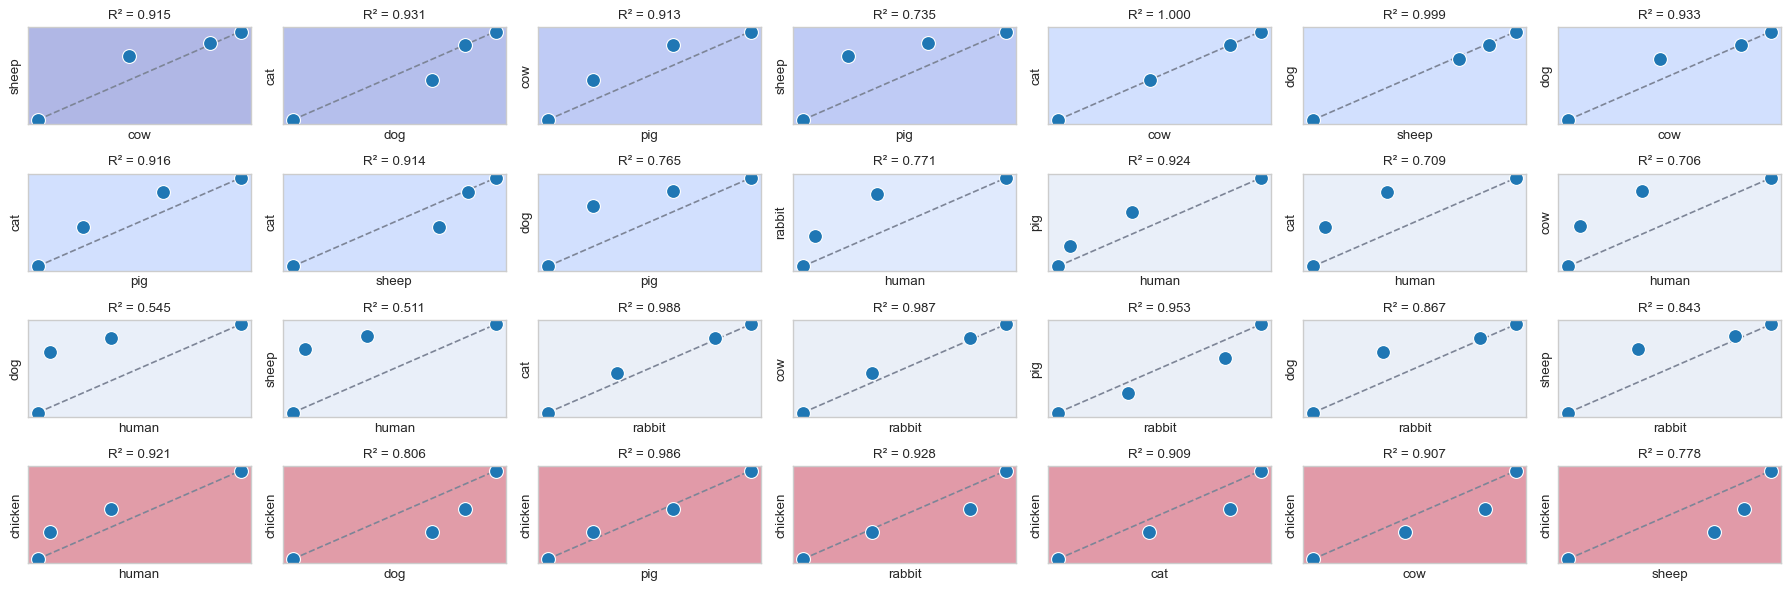

In [16]:
import matplotlib.colors as mcolors

aln = "hrmrrcspcdc" 
tree = Tree("vertebrate_tree_mya.nw", format=1)
root_node = tree.get_tree_root()
species = get_code_conversion(aln).split(';')

sb_coord = get_sb_len(species,aln)
tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)

i = ("Alignment300")
count = tad_sb_count_df.loc[tad_sb_count_df.aln == i]
filtered_df = count.groupby('count').size().sort_values(ascending=False)
max_count = filtered_df.index[0]
# max_count = filtered_df.index[1]
count = count[count['count'] == max_count]

# comb = [('dog', 'cat'), ('pig', 'cow'),('cow', 'cat'),('mouse', 'pig'),('dog', 'chicken')] #HoxA
# comb = [('human', 'rhesus'),('dog', 'cat'),('pig', 'dog'),('human', 'mouse'),('rat', 'cat')]  #SIX 
# comb = [('pig', 'cat'),('sheep', 'cat'),('human', 'rabbit'),('human', 'sheep'),('human', 'cat'),('human', 'pig'),('rabbit', 'cat'),('human', 'chicken')]
# comb = [('human', 'pig'), ('human', 'sheep'), ('human', 'cat'), ('human', 'chicken'), ('rabbit', 'pig'), ('rabbit', 'sheep'), ('rabbit', 'cat'), ('rabbit', 'chicken'), ('pig', 'sheep'), ('pig', 'cat'), ('pig', 'chicken'), ('sheep', 'cat'), ('sheep', 'chicken'), ('cat', 'chicken')]
comb = list(combinations(count.species, 2))
print(len(comb))
res= []
for s1,s2 in comb:
    node1 = tree.search_nodes(name=s1)[0]
    node2 = tree.search_nodes(name=s2)[0]
    parent_node = tree.get_common_ancestor(node1, node2)
    distance = round(parent_node.get_distance(node1))
    tad_coord = tad_sb_coord_df.loc[((tad_sb_coord_df.species == s1) | (tad_sb_coord_df.species == s2))& (tad_sb_coord_df.aln==i)].copy()
    result,bound =map_tad_boundaries_single(tad_coord, (s1,s2))
    if not result.empty:
        score = result['Border Similarity'].values[0]
        res.append([(s1,s2),distance,score])

dfs = pd.DataFrame(res,columns=["species","distance","r2"])
sorted_by_distance = dfs.sort_values(by=['distance', 'r2'], ascending=[True, False])
print(sorted_by_distance)
 
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(18, 6))
cmap_custom = plt.cm.coolwarm

min_distance = sorted_by_distance['distance'].min()
max_distance = sorted_by_distance['distance'].max()

# Create normalization object
# norm = Normalize(vmin=50, vmax=320)
norm = mcolors.TwoSlopeNorm(vmin=50, vcenter=100, vmax=320)


sp_pair = sorted_by_distance.species
for  j,(s1,s2) in enumerate(sp_pair):    
    ax = axes.flatten()[j]
    node1 = tree.search_nodes(name=s1)[0]
    node2 = tree.search_nodes(name=s2)[0]
    parent_node = tree.get_common_ancestor(node1, node2)
    distance = round(parent_node.get_distance(node1),1)
    tad_coord = tad_sb_coord_df.loc[((tad_sb_coord_df.species == s1) | (tad_sb_coord_df.species == s2))& (tad_sb_coord_df.aln==i)].copy()
    result,bound =map_tad_boundaries_single(tad_coord, (s1,s2))
    mapped_tad_boundaries = pd.DataFrame.from_dict(bound[0])
    sns.lineplot(x=[0, 1], y=[0, 1],color='#7d8597',linestyle='--', label="Linear Regression Line",ax=ax,legend=False)
    sns.scatterplot(data=mapped_tad_boundaries, x=mapped_tad_boundaries.columns.values[0], y=mapped_tad_boundaries.columns.values[1],label="TAD border",s=100,ax=ax,legend=False,zorder=2)
    score = result['Border Similarity'].values[0]
    ax.set_title(f"R\N{SUPERSCRIPT TWO} = {score:.3f}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_facecolor(cmap_custom(norm(distance)))
    ax.patch.set_alpha(.4)
    # ax.patch.set_alpha(0.2)

# Remove extra empty plots
for k in range(len(sp_pair), len(axes.flatten())):
    fig.delaxes(axes.flatten()[k])
# 
# sm = plt.cm.ScalarMappable(cmap=cmap_custom, norm=norm)
# sm.set_array([])  
# cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.2, pad=.10)
# cbar.set_label('Evolutionary Closeness')

plt.tight_layout()
# plt.savefig("../images/figure 4/aln142_tad_border.png",bbox_inches="tight")
plt.show()

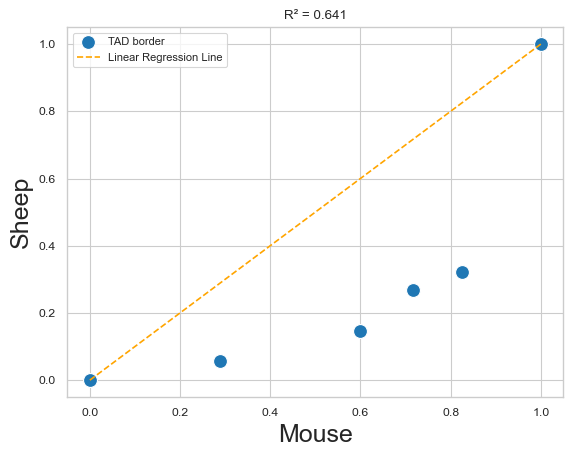

In [36]:
#  #Plot similar blocks
# species = get_code_conversion(aln).split(';')
# 
# sb_coord = get_sb_len(species,aln)
# tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
# 
# # plt.figure(figsize=(15, 11)) 
# tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
# tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)
# i = ("mouse","sheep")
# syn_block = ["Alignment83"]
# tad_coord = tad_sb_coord_df.loc[((tad_sb_coord_df.species == i[0]) | (tad_sb_coord_df.species == i[1]))& (tad_sb_coord_df.aln.isin(syn_block))].copy()
# result,bound =map_tad_boundaries_single(tad_coord, i)
# mapped_tad_boundaries = pd.DataFrame.from_dict(bound[0])
# sns.scatterplot(data=mapped_tad_boundaries, x="mouse", y="sheep",label="TAD border",s=100)
# sns.lineplot(x=[0, 1], y=[0, 1],color='orange',linestyle='--', label="Linear Regression Line",zorder=10)
# plt.xlabel("Mouse",fontsize=18)
# plt.ylabel("Sheep",fontsize=18)
# plt.legend(fontsize=8)
# plt.title( "R\N{SUPERSCRIPT TWO} = {:.3f}".format(result['Border Similarity'].values[0]))
# # plt.savefig("images/tad_border_r2_line_m_s_83.png", bbox_inches='tight')
# plt.show()

('human', 'mouse') 27
('mouse', 'dog') 11
('human', 'dog') 27
('human', 'sheep') 27
('mouse', 'sheep') 11
('dog', 'sheep') 55


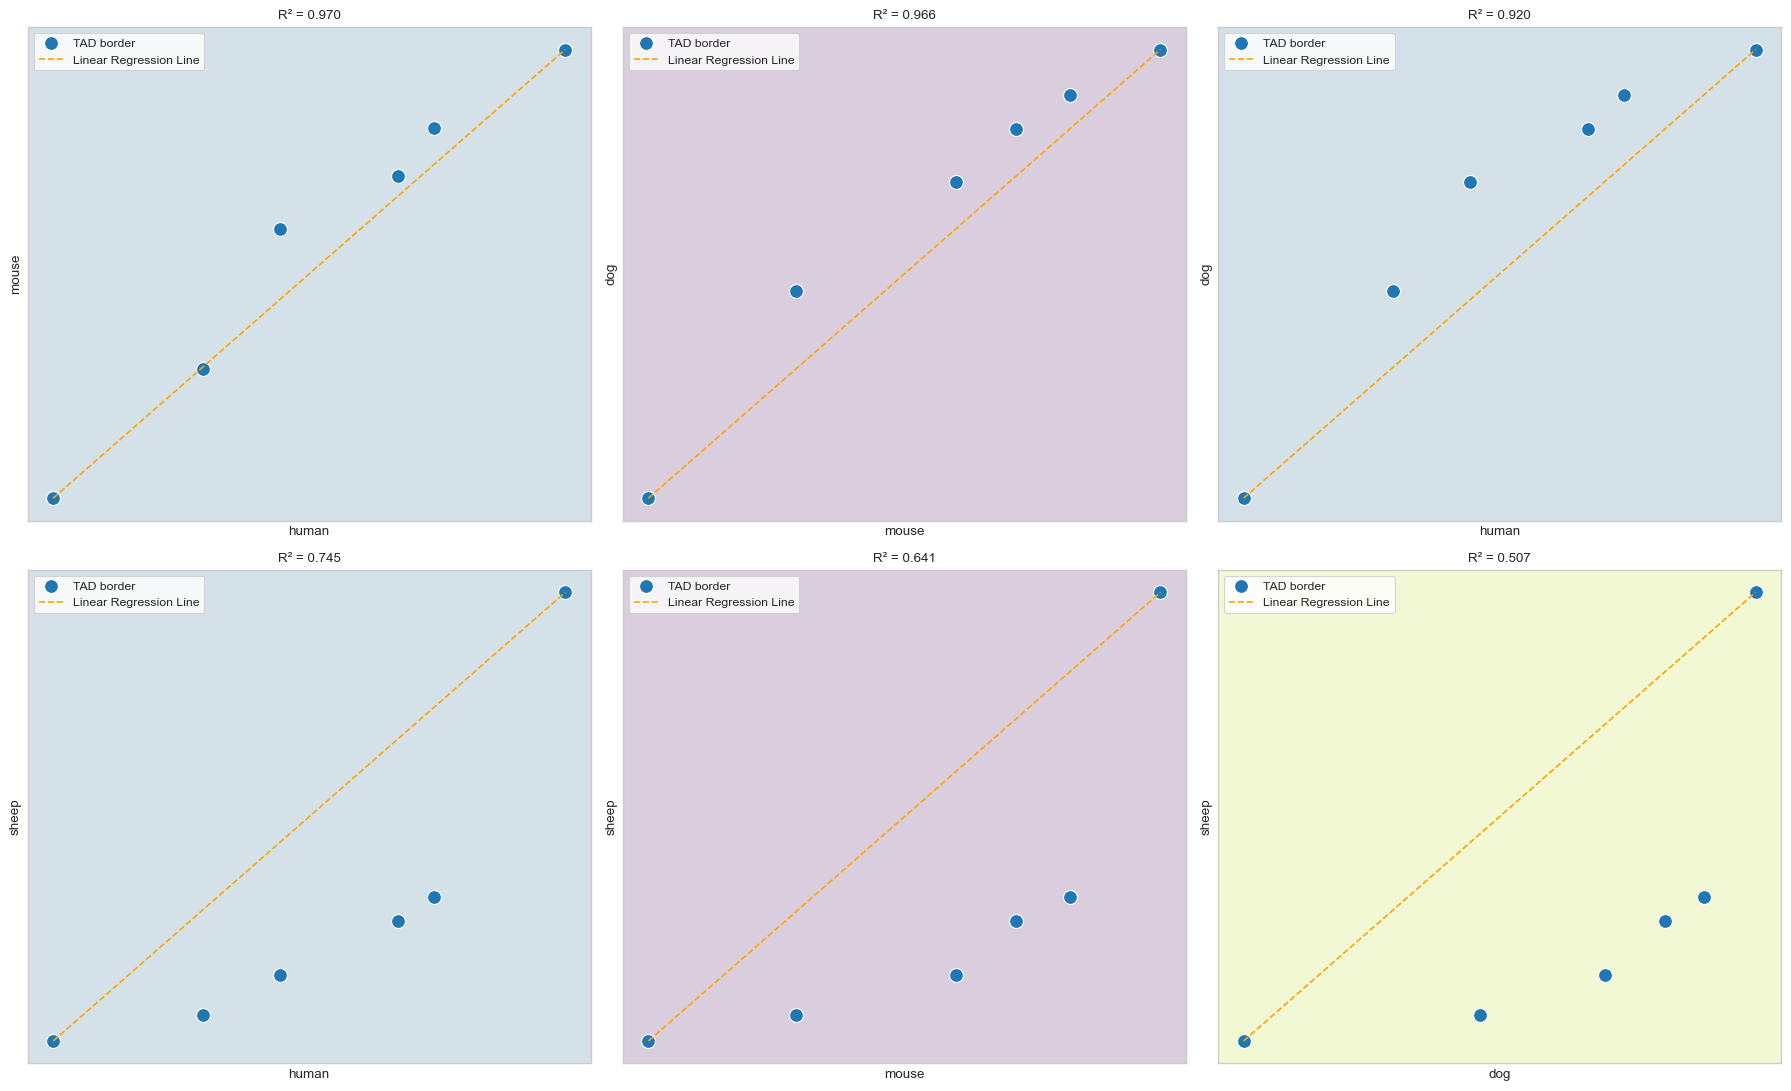

In [37]:
# aln = "hrmrrcspcdc"
# syn_block = ["Alignment83"]
# species = get_code_conversion(aln).split(';')
# sb_coord = get_sb_len(species,aln)
# 
# tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
# tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
# tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)
# comb = [('human', 'mouse'),('mouse', 'dog'), ('human', 'dog'), ('human', 'sheep'), ('mouse', 'sheep'), ('dog', 'sheep')]
# 
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 11))
# cmap = plt.cm.viridis 
# # cmap = plt.cm.seismic  
# norm = plt.Normalize(vmin=10, vmax=60)
# # norm = plt.Normalize(vmin=0.5, vmax=1)
# 
# 
# for  i,(s1,s2) in enumerate(comb):    
#     ax = axes.flatten()[i]
#     node1 = tree.search_nodes(name=s1)[0]
#     node2 = tree.search_nodes(name=s2)[0]
#     parent_node = node1.up
#     distance = round(parent_node.get_distance(node1))
#     print((s1,s2),distance)
#     tad_coord = tad_sb_coord_df.loc[((tad_sb_coord_df.species == s1) | (tad_sb_coord_df.species == s2))& (tad_sb_coord_df.aln.isin(syn_block))].copy()
#     result,bound =map_tad_boundaries_single(tad_coord, (s1,s2))
#     mapped_tad_boundaries = pd.DataFrame.from_dict(bound[0])
#     sns.scatterplot(data=mapped_tad_boundaries, x=mapped_tad_boundaries.columns.values[0], y=mapped_tad_boundaries.columns.values[1],label="TAD border",s=100,ax=ax)
#     sns.lineplot(x=[0, 1], y=[0, 1],color='orange',linestyle='--', label="Linear Regression Line",zorder=10,ax=ax)
#     score = result['Border Similarity'].values[0]
#     ax.set_title(f"R\N{SUPERSCRIPT TWO} = {score:.3f}")
#     ax.set_xticks([])
#     ax.set_yticks([])
# 
#     # Color intensity based on score
#     ax.patch.set_facecolor(cmap(norm(distance)))
#     # ax.patch.set_facecolor(cmap(norm(score)))
#     ax.patch.set_alpha(0.2)
# 
# # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# # sm.set_array([])  
# # cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.4)
# # cbar.set_label('Evolutionary Closeness Score')
# 
# plt.tight_layout()
# plt.show()

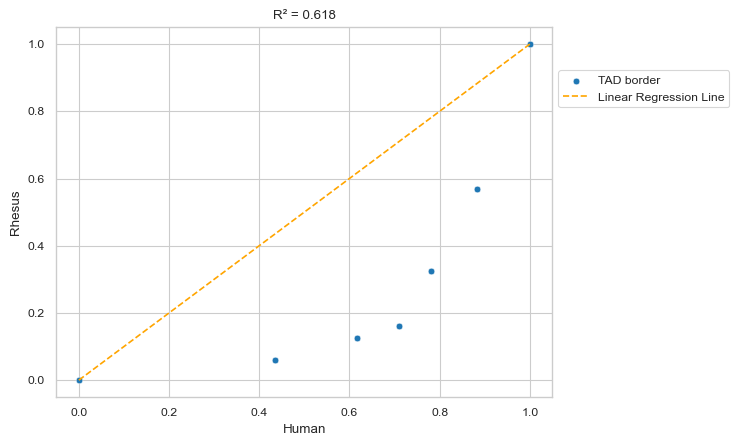

In [38]:
# #Plot similar blocks
# aln = "hrmrrcspcd" 
# species = get_code_conversion(aln).split(';')
# 
# sb_coord = get_sb_len(species,aln)
# tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
# 
# tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
# tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)
# i = ("human", "rhesus")
# syn_block = ["Alignment4"]
# tad_coord = tad_sb_coord_df.loc[((tad_sb_coord_df.species == i[0]) | (tad_sb_coord_df.species == i[1]))& (tad_sb_coord_df.aln.isin(syn_block))].copy()
# result,bound =map_tad_boundaries_single(tad_coord, i)
# mapped_tad_boundaries = pd.DataFrame.from_dict(bound[0])
# sns.scatterplot(data=mapped_tad_boundaries, x="human", y="rhesus",label="TAD border")
# sns.lineplot(x=[0, 1], y=[0, 1],color='orange',linestyle='--', label="Linear Regression Line",zorder=10)
# plt.xlabel("Human")
# plt.ylabel("Rhesus")
# plt.legend(bbox_to_anchor=(1, .9))
# plt.title( "R\N{SUPERSCRIPT TWO} = {:.3f}".format(result['Border Similarity'].values[0]))
# # plt.savefig("images/tad_border_r2_line.png", bbox_inches='tight')
# plt.show()

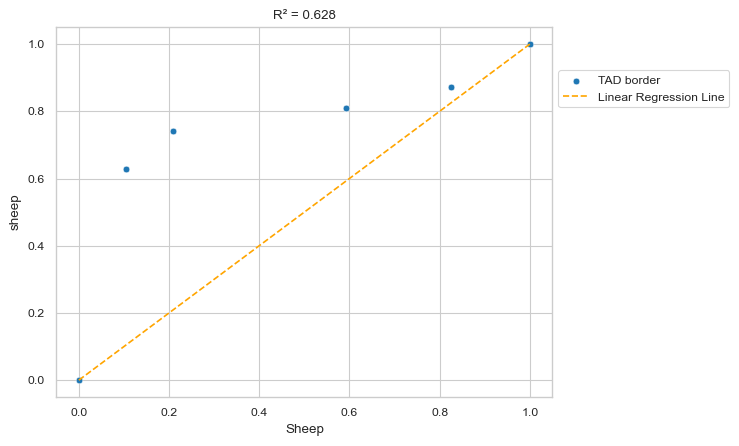

In [39]:
# #Plot similar blocks
# aln = "hrmrrcspcd" 
# species = get_code_conversion(aln).split(';')
# 
# sb_coord = get_sb_len(species,aln)
# tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
# 
# tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
# tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)
# i = ("rhesus","sheep")
# syn_block = ["Alignment184"]
# tad_coord = tad_sb_coord_df.loc[((tad_sb_coord_df.species == i[0]) | (tad_sb_coord_df.species == i[1]))& (tad_sb_coord_df.aln.isin(syn_block))].copy()
# result,bound =map_tad_boundaries_single(tad_coord, i)
# 
# mapped_tad_boundaries = pd.DataFrame.from_dict(bound[0])
# 
# sns.scatterplot(data=mapped_tad_boundaries, x="rhesus", y="sheep",label="TAD border")
# sns.lineplot(x=[0, 1], y=[0, 1],color='orange',linestyle='--', label="Linear Regression Line",zorder=10)
# plt.xlabel("Rhesus")
# plt.xlabel("Sheep")
# plt.legend(bbox_to_anchor=(1, .9))
# plt.title( "R\N{SUPERSCRIPT TWO} = {:.3f}".format(result['Border Similarity'].values[0]))
# # plt.figtext(.92, 0.81, "R\N{SUPERSCRIPT TWO} = {:.3f}".format(result['Border Similarity'].values[0]), ha='left')
# # plt.savefig("images/tad_border_r2_line.png", bbox_inches='tight')
# plt.show()

In [20]:
# dff.loc[dff.Aln=="Alignment251"]

In [21]:
# #Plot similar blocks
# aln = "hrmrrcspcdc" 
# species = get_code_conversion(aln).split(';')
# 
# sb_coord = get_sb_len(species,aln)
# tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
# 
# tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
# tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)
# i = ("sheep","cat")
# syn_block = ["Alignment251"]
# tad_coord = tad_sb_coord_df.loc[((tad_sb_coord_df.species == i[0]) | (tad_sb_coord_df.species == i[1]))& (tad_sb_coord_df.aln.isin(syn_block))].copy()
# result,bound =map_tad_boundaries_single(tad_coord, i)
# 
# mapped_tad_boundaries = pd.DataFrame.from_dict(bound[0])
# 
# sns.scatterplot(data=mapped_tad_boundaries, x="sheep", y="cat",label="TAD border")
# sns.lineplot(x=[0, 1], y=[0, 1],color='orange',linestyle='--', label="Linear Regression Line",zorder=10)
# plt.xlabel("Rhesus")
# plt.xlabel("Sheep")
# plt.legend(bbox_to_anchor=(1, .9))
# plt.title( "R\N{SUPERSCRIPT TWO} = {:.3f}".format(result['Border Similarity'].values[0]))
# # plt.figtext(.92, 0.81, "R\N{SUPERSCRIPT TWO} = {:.3f}".format(result['Border Similarity'].values[0]), ha='left')
# # plt.savefig("images/tad_border_r2_line.png", bbox_inches='tight')
# plt.show()

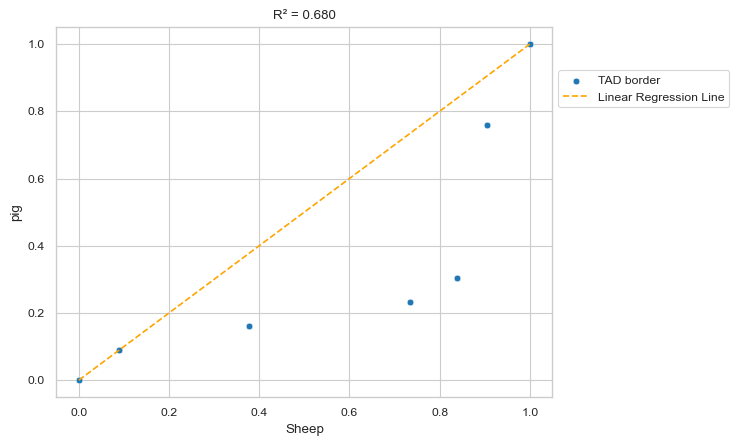

In [35]:
# #Plot similar blocks
# aln = "hrmrrcspcdc" 
# species = get_code_conversion(aln).split(';')
# 
# sb_coord = get_sb_len(species,aln)
# tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
# 
# tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
# tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)
# i = ("rhesus","pig")
# syn_block = ["Alignment50"]
# tad_coord = tad_sb_coord_df.loc[((tad_sb_coord_df.species == i[0]) | (tad_sb_coord_df.species == i[1]))& (tad_sb_coord_df.aln.isin(syn_block))].copy()
# result,bound =map_tad_boundaries_single(tad_coord, i)
# 
# mapped_tad_boundaries = pd.DataFrame.from_dict(bound[0])
# 
# sns.scatterplot(data=mapped_tad_boundaries, x="rhesus", y="pig",label="TAD border")
# sns.lineplot(x=[0, 1], y=[0, 1],color='orange',linestyle='--', label="Linear Regression Line",zorder=10)
# plt.xlabel("Rhesus")
# plt.xlabel("Sheep")
# plt.legend(bbox_to_anchor=(1, .9))
# plt.title( "R\N{SUPERSCRIPT TWO} = {:.3f}".format(result['Border Similarity'].values[0]))
# # plt.figtext(.92, 0.81, "R\N{SUPERSCRIPT TWO} = {:.3f}".format(result['Border Similarity'].values[0]), ha='left')
# # plt.savefig("images/tad_border_r2_line.png", bbox_inches='tight')
# plt.show()

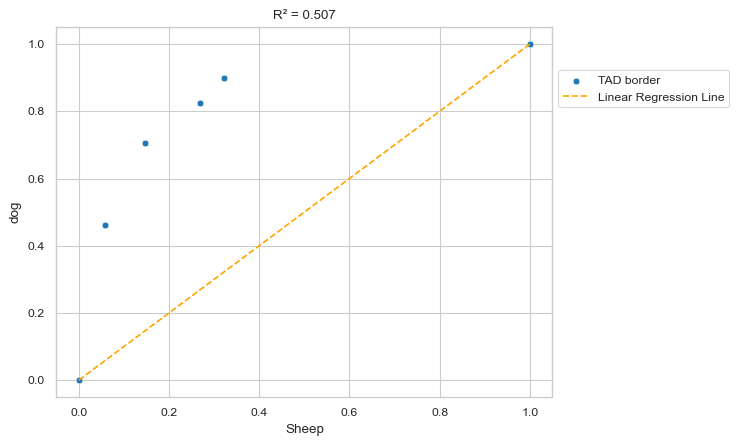

In [34]:
# #Plot similar blocks
# aln = "hrmrrcspcdc" 
# species = get_code_conversion(aln).split(';')
# 
# sb_coord = get_sb_len(species,aln)
# tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
# 
# tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
# tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)
# i = ("sheep","dog")
# syn_block = ["Alignment83"]
# tad_coord = tad_sb_coord_df.loc[((tad_sb_coord_df.species == i[0]) | (tad_sb_coord_df.species == i[1]))& (tad_sb_coord_df.aln.isin(syn_block))].copy()
# result,bound =map_tad_boundaries_single(tad_coord, i)
# 
# mapped_tad_boundaries = pd.DataFrame.from_dict(bound[0])
# 
# sns.scatterplot(data=mapped_tad_boundaries, x="sheep", y="dog",label="TAD border")
# sns.lineplot(x=[0, 1], y=[0, 1],color='orange',linestyle='--', label="Linear Regression Line",zorder=10)
# plt.xlabel("Rhesus")
# plt.xlabel("Sheep")
# plt.legend(bbox_to_anchor=(1, .9))
# plt.title( "R\N{SUPERSCRIPT TWO} = {:.3f}".format(result['Border Similarity'].values[0]))
# # plt.figtext(.92, 0.81, "R\N{SUPERSCRIPT TWO} = {:.3f}".format(result['Border Similarity'].values[0]), ha='left')
# # plt.savefig("images/tad_border_r2_line.png", bbox_inches='tight')
# plt.show()

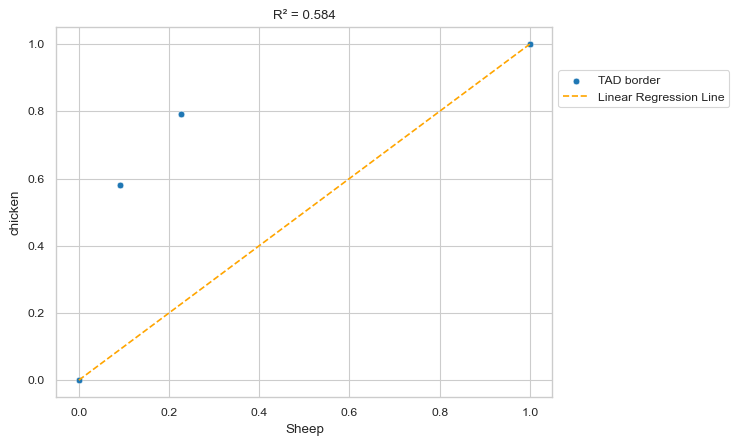

In [33]:
# #Plot similar blocks
# aln = "hrmrrcspcdc" 
# species = get_code_conversion(aln).split(';')
# 
# sb_coord = get_sb_len(species,aln)
# tad_sb_count_list, tad_sb_coord_list = get_tad_in_sb(species, aln,sb_coord)
# 
# tad_sb_count_df = pd.concat(tad_sb_count_list, axis=0)
# tad_sb_coord_df = pd.concat(tad_sb_coord_list, axis=0)
# i = ("human","chicken")
# syn_block = ["Alignment142"]
# tad_coord = tad_sb_coord_df.loc[((tad_sb_coord_df.species == i[0]) | (tad_sb_coord_df.species == i[1]))& (tad_sb_coord_df.aln.isin(syn_block))].copy()
# result,bound =map_tad_boundaries_single(tad_coord, i)
# 
# mapped_tad_boundaries = pd.DataFrame.from_dict(bound[0])
# 
# sns.scatterplot(data=mapped_tad_boundaries, x="human", y="chicken",label="TAD border")
# sns.lineplot(x=[0, 1], y=[0, 1],color='orange',linestyle='--', label="Linear Regression Line",zorder=10)
# plt.xlabel("Rhesus")
# plt.xlabel("Sheep")
# plt.legend(bbox_to_anchor=(1, .9))
# plt.title( "R\N{SUPERSCRIPT TWO} = {:.3f}".format(result['Border Similarity'].values[0]))
# # plt.figtext(.92, 0.81, "R\N{SUPERSCRIPT TWO} = {:.3f}".format(result['Border Similarity'].values[0]), ha='left')
# # plt.savefig("images/tad_border_r2_line.png", bbox_inches='tight')
# plt.show()
